In [25]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
superbowl_yt = pd.read_csv("../data/superbowls/youtube.csv")

In [27]:
superbowl_yt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       247 non-null    int64  
 1   brand                      247 non-null    object 
 2   superbowl_ads_dot_com_url  247 non-null    object 
 3   youtube_url                236 non-null    object 
 4   funny                      247 non-null    bool   
 5   show_product_quickly       247 non-null    bool   
 6   patriotic                  247 non-null    bool   
 7   celebrity                  247 non-null    bool   
 8   danger                     247 non-null    bool   
 9   animals                    247 non-null    bool   
 10  use_sex                    247 non-null    bool   
 11  id                         236 non-null    object 
 12  kind                       231 non-null    object 
 13  etag                       231 non-null    object 

In [28]:
def clean_superbowl_data(df):
    # 1. Clean Boolean Columns
    # These columns represent the characteristics of the ads (e.g., funny, patriotic)
    bool_cols = [
        'funny', 'show_product_quickly', 'patriotic', 'celebrity', 
        'danger', 'animals', 'use_sex'
    ]
    for col in bool_cols:
        # Fill missing with False and convert to boolean
        df[col] = df[col].fillna(False).astype(bool)

    # 2. Clean YouTube Statistics
    # Converting counts to 'Int64' (nullable integer) because some ads may 
    # have missing stats if they were deleted or private when the API was scraped.
    numeric_cols = [
        'view_count', 'like_count', 'dislike_count', 
        'favorite_count', 'comment_count'
    ]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

    # 3. Clean Date Column
    # Convert published_at from string to datetime
    df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce')

    # 4. Extract YouTube ID (mimicking the R script's mutate logic)
    # The R script used str_remove to create a clean ID from the URL
    if 'youtube_url' in df.columns:
        df['youtube_id'] = df['youtube_url'].str.replace(
            r'https://www.youtube.com/watch\?v=', '', regex=True
        )

    # 5. Final Tidying
    # Sort by year and brand for better organization
    df = df.sort_values(['year', 'brand'], ascending=[False, True]).reset_index(drop=True)
    
    return df


In [29]:
superbowl_yt_clean = clean_superbowl_data(superbowl_yt)
superbowl_yt_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   year                       247 non-null    int64              
 1   brand                      247 non-null    object             
 2   superbowl_ads_dot_com_url  247 non-null    object             
 3   youtube_url                236 non-null    object             
 4   funny                      247 non-null    bool               
 5   show_product_quickly       247 non-null    bool               
 6   patriotic                  247 non-null    bool               
 7   celebrity                  247 non-null    bool               
 8   danger                     247 non-null    bool               
 9   animals                    247 non-null    bool               
 10  use_sex                    247 non-null    bool               
 11  id    

In [30]:
def analyze_engagement(df):
    # Data Cleaning
    bool_cols = [
        'funny', 'show_product_quickly', 'patriotic', 
        'celebrity', 'danger', 'animals', 'use_sex'
    ]
    
    # Fill missing values and ensure boolean type
    for col in bool_cols:
        df[col] = df[col].fillna(False).astype(bool)

    # Convert counts to numeric and handle missing values
    df['view_count'] = pd.to_numeric(df['view_count'], errors='coerce')
    df['like_count'] = pd.to_numeric(df['like_count'], errors='coerce')
    
    # Drop rows with zero or missing views to avoid division by zero
    df_clean = df.dropna(subset=['view_count', 'like_count'])
    df_clean = df_clean[df_clean['view_count'] > 0].copy()

    # 2. Calculate Like/View Ratio (as a percentage)
    # Ratio = (Likes / Views) * 100
    df_clean['like_ratio_pct'] = (df_clean['like_count'] / df_clean['view_count']) * 100

    # 3. Aggregate results for each category
    engagement_results = []
    for col in bool_cols:
        # Filter for ads that HAVE this characteristic (True)
        avg_ratio = df_clean[df_clean[col] == True]['like_ratio_pct'].mean()
        
        engagement_results.append({
            'Characteristic': col.replace('_', ' ').title(),
            'Avg Like Ratio (%)': avg_ratio
        })

    # Create a summary DataFrame and sort by the ratio
    summary_df = pd.DataFrame(engagement_results).sort_values(
        by='Avg Like Ratio (%)', ascending=False
    )
    
    return summary_df

In [31]:
engagement_summary = analyze_engagement(superbowl_yt_clean)

/var/folders/2k/z1qr202s5kn8gjb943s4jrpr0000gn/T/ipykernel_72979/353741762.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


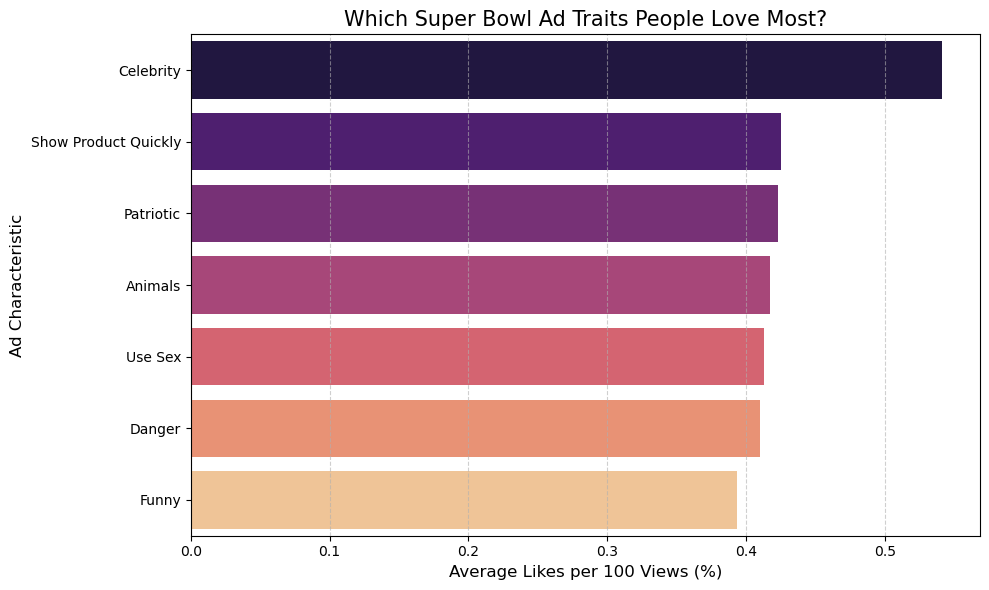

Ranked Ad Characteristics by Engagement:
      Characteristic  Avg Like Ratio (%)
           Celebrity            0.541533
Show Product Quickly            0.425074
           Patriotic            0.423049
             Animals            0.417194
             Use Sex            0.412905
              Danger            0.409962
               Funny            0.393382


In [32]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=engagement_summary, 
    x='Avg Like Ratio (%)', 
    y='Characteristic', 
    palette='magma'
)

plt.title('Which Super Bowl Ad Traits People Love Most?', fontsize=15)
plt.xlabel('Average Likes per 100 Views (%)', fontsize=12)
plt.ylabel('Ad Characteristic', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Display the ranked table
print("Ranked Ad Characteristics by Engagement:")
print(engagement_summary.to_string(index=False))

In [33]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [34]:
bool_cols = ['funny', 'show_product_quickly', 'patriotic', 'celebrity', 'danger', 'animals', 'use_sex']
brand_profiles = superbowl_yt_clean.groupby('brand')[bool_cols].mean()


n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
brand_profiles['cluster'] = kmeans.fit_predict(brand_profiles)

pca = PCA(n_components=2)
pca_components = pca.fit_transform(brand_profiles.drop('cluster', axis=1))
brand_profiles['pca_1'] = pca_components[:, 0]
brand_profiles['pca_2'] = pca_components[:, 1]

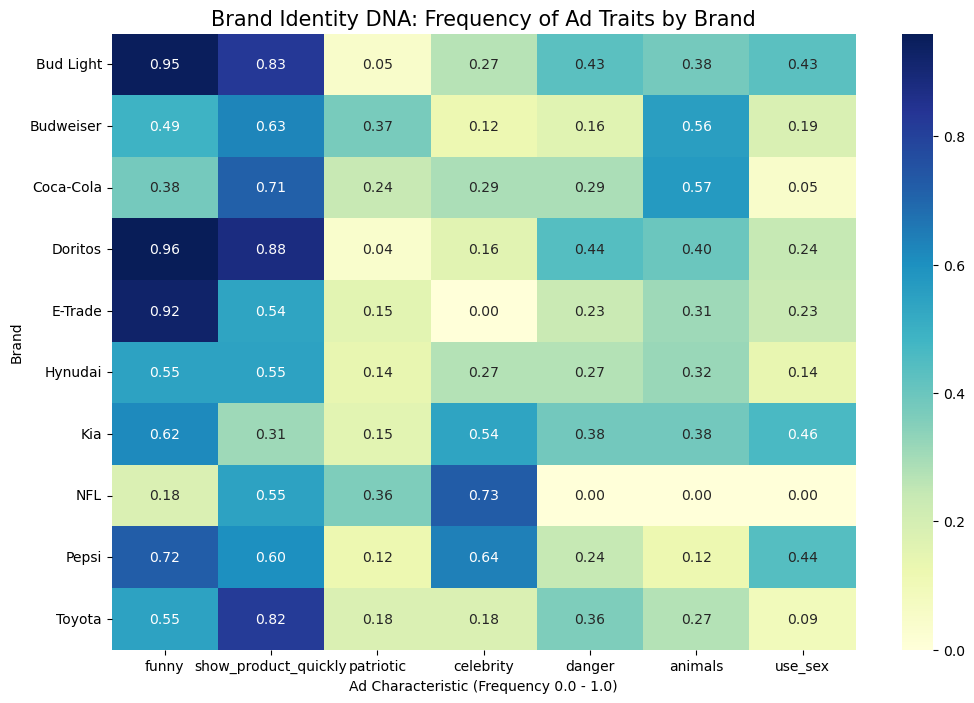

In [35]:
# --- VISUALIZATION 1: The Brand DNA Heatmap ---
plt.figure(figsize=(12, 8))
sns.heatmap(brand_profiles.drop(['cluster', 'pca_1', 'pca_2'], axis=1), 
            annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Brand Identity DNA: Frequency of Ad Traits by Brand", fontsize=15)
plt.ylabel("Brand")
plt.xlabel("Ad Characteristic (Frequency 0.0 - 1.0)")
plt.show()



/var/folders/2k/z1qr202s5kn8gjb943s4jrpr0000gn/T/ipykernel_72979/429273333.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(brand_profiles.pca_1[i]+0.02, brand_profiles.pca_2[i]+0.02,


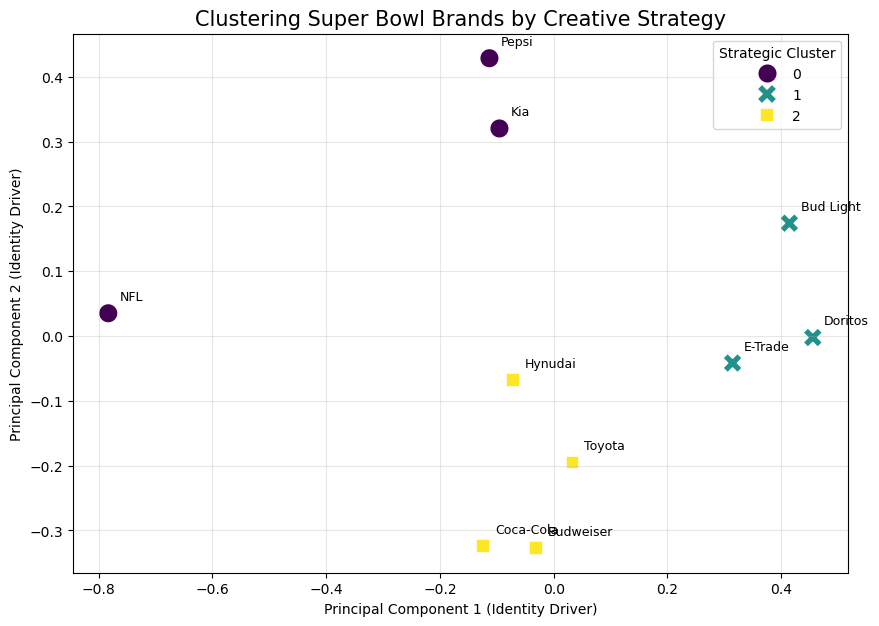


--- Brand Cluster Profiles (Means) ---
            funny  show_product_quickly  patriotic  celebrity    danger  \
cluster                                                                   
0        0.505734              0.484382   0.212494   0.635245  0.208205   
1        0.945153              0.747953   0.080488   0.143280  0.366447   
2        0.490058              0.676457   0.232093   0.214135  0.271217   

          animals   use_sex  
cluster                      
0        0.168205  0.300513  
1        0.362882  0.299780  
2        0.430119  0.115235  


In [36]:
# --- VISUALIZATION 2: Cluster Scatter Plot ---
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=brand_profiles, x='pca_1', y='pca_2', 
    hue='cluster', style='cluster', s=200, palette='viridis'
)

# Annotate each point with the brand name
for i in range(brand_profiles.shape[0]):
    plt.text(brand_profiles.pca_1[i]+0.02, brand_profiles.pca_2[i]+0.02, 
             brand_profiles.index[i], fontsize=9)

plt.title("Clustering Super Bowl Brands by Creative Strategy", fontsize=15)
plt.xlabel("Principal Component 1 (Identity Driver)")
plt.ylabel("Principal Component 2 (Identity Driver)")
plt.legend(title="Strategic Cluster")
plt.grid(alpha=0.3)
plt.show()

print("\n--- Brand Cluster Profiles (Means) ---")
print(brand_profiles.groupby('cluster')[bool_cols].mean())